#Problems Encountered
If training in collab, batch and PM needs to be combined such that GPU memory is lower than 15GB

#References

##Data
https://www.kaggle.com/sharmayush/person2anime/activity

##Model 
https://github.com/arnab39/cycleGAN-PyTorch/blob/master/model.py

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

https://github.com/cy-xu/simple_CycleGAN

https://arxiv.org/pdf/1703.10593.pdf

# Imports

In [ ]:
import torch.nn as nn
import torch
import itertools

import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#Config


In [ ]:
use_cuda = True
multiGPU = False

In [ ]:
DEBUG = False
OVERFIT = 50

In [ ]:
BATCH_SIZE = 1
NUM_WORKERS = 4
MAX_POOL = 50

In [ ]:
PM = 64
#Parameter Multiplier 
#The value is 64 in the paper, but takes too long to train so its reduced to 16

In [ ]:
root_dir = 'drive/My Drive/CSC420'
save_dir = 'drive/My Drive/CSC420/state_dict'

#Mount and Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
# root = 'drive/My Drive/CSC420'
root = root_dir

dir_A = root+'/dataset/face2anime/ltrainA'
dir_B = root+'/dataset/face2anime/ltrainB'
t_dir_A = root+'/dataset/face2anime/ltestA'
t_dir_B = root+'/dataset/face2anime/ltestB'

In [ ]:
_transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.Resize((128,128)),
        transforms.ToTensor(), #to tensor deals within uint8 type
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

SetA = torchvision.datasets.ImageFolder(root=dir_A, transform=_transform)
SetB = torchvision.datasets.ImageFolder(root=dir_B, transform=_transform)
testA = torchvision.datasets.ImageFolder(root=t_dir_A, transform=_transform)
testB = torchvision.datasets.ImageFolder(root=t_dir_A, transform=_transform)
#instance = ([3,128,128],0)

In [ ]:
Shuffle=True #Set to True if u want to run entire batch instead of just overfitting 
Batch_size = BATCH_SIZE
Workers = NUM_WORKERS #set this relative to num of avalaible GPU, ask Mickel

LoaderA = torch.utils.data.DataLoader(SetA, batch_size=Batch_size,shuffle=Shuffle, num_workers=Workers)
LoaderB = torch.utils.data.DataLoader(SetB, batch_size=Batch_size,shuffle=Shuffle, num_workers=Workers)

LoadertestA = torch.utils.data.DataLoader(SetA, batch_size=Batch_size, shuffle=Shuffle, num_workers=Workers)
LoadertestB = torch.utils.data.DataLoader(SetB, batch_size=Batch_size, shuffle=Shuffle, num_workers=Workers)
#instance = loader([batch_size, 3, 128, 128], batch_size)

# Models


## Generator

In [ ]:
class Generator_Res(nn.Module):
    def __init__(self, inchannels = 3, outchannels = 3, pm=PM):
        super(Generator_Res, self).__init__()
        self.model = nn.Sequential(
            #Downsampling
            nn.ReflectionPad2d(3),

            nn.Conv2d(in_channels=inchannels, out_channels=pm*1, kernel_size=7, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(pm * 1),
            nn.ReLU(True),

            nn.Conv2d(in_channels=pm*1, out_channels=pm * 2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(pm * 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=pm*2, out_channels=pm*4, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(pm * 4),
            nn.ReLU(True),

            #Resblocks
            #I dont know if dropout is gunna help
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(pm * 4),
            nn.Dropout(0.5),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(pm * 4),
            nn.Dropout(0.5),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(pm * 4),
            nn.Dropout(0.5),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(pm * 4),
            nn.Dropout(0.5),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(pm * 4),
            nn.Dropout(0.5),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(pm * 4),
            nn.Dropout(0.5),

            #Upsampling
            nn.ConvTranspose2d(in_channels=pm * 4, out_channels=pm * 2, kernel_size=3, stride=2, padding=1,
                               output_padding=1),
            nn.BatchNorm2d(pm * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=pm * 2, out_channels=pm * 1, kernel_size=3, stride=2, padding=1,
                               output_padding=1),
            nn.BatchNorm2d(pm * 1),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(pm, outchannels, 7),
            nn.Tanh()
        )

        if (multiGPU):
            self.model = nn.DataParallel(self.model)
            
    def forward(self, x):
        return self.model(x)

## Discriminator


In [ ]:
class Discriminator_Patch(nn.Module):
    def __init__(self, inchannels = 3, outchannels=1, pm=PM):
        super(Discriminator_Patch, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=inchannels, out_channels=pm *1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels = pm * 1, out_channels=pm * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(pm * 2),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=pm * 2, out_channels=pm * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(pm * 4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(pm * 4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(pm * 4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=pm * 4, out_channels=outchannels, kernel_size=4, stride=1, padding=1)
        )
        if (multiGPU):
            self.model = nn.DataParallel(self.model)

    def forward(self, x):
        return self.model(x)

# Training Function

##Random Pooling for fakes

In [ ]:
def Rand_pool(cur_list, cur_fake):
  if len(cur_list) < MAX_POOL:
    cur_list.append(cur_fake)
    out_fake = cur_fake
  else:
    if np.random.ranf() > 0.5:
      index = np.random.randint(0, MAX_POOL)
      out_fake = cur_list[index].copy()
      cur_list[index] = cur_fake
    else:
      out_fake = cur_fake
  return cur_list, out_fake

##Training Function

###v1.0

In [ ]:
def train(LoaderA, LoaderB, Gen_A, Gen_B, Dis_A, Dis_B, session,
          G_lambda=10, G_idtcoeff=0.5, g_lr=0.005, d_lr=0.005, 
          epochs=10, s_epoch=10):
    ##########################Initialization######################################
    criterionMSE = nn.MSELoss()
    criterionL1 = nn.L1Loss()

    #TODO Schedule lr
    G_optimizer = torch.optim.Adam(itertools.chain(Gen_A.parameters(),Gen_B.parameters()), lr=g_lr, betas=(0.5, 0.999))
    D_optimizer = torch.optim.Adam(itertools.chain(Dis_A.parameters(), Dis_B.parameters()), lr=d_lr, betas=(0.5, 0.999))


    try:
      checkpoint = torch.load(save_dir+'/'+session)
      assert checkpoint['PM']==PM, 'Bruh reinitialize model, PM does not match'
      loaded_epoch = checkpoint['epoch']
      track_loss = checkpoint['losses']
      Gen_A.load_state_dict(checkpoint['Gen_A_sd'])
      Gen_B.load_state_dict(checkpoint['Gen_B_sd'])
      Dis_A.load_state_dict(checkpoint['Dis_A_sd'])
      Dis_B.load_state_dict(checkpoint['Dis_B_sd'])
      G_optimizer.load_state_dict(checkpoint['G_opt_sd'])
      D_optimizer.load_state_dict(checkpoint['D_opt_sd'])
      Gen_LR = checkpoint['G_LR']
      Dis_LR = checkpoint['D_LR']
      print("{} found, loading".format(session))


    except:
      print("{} is not found, making new file".format(session))
      loaded_epoch = 0
      track_loss = []
      Gen_LR = []
      Dis_LR = []

    Rand_pool_A = []
    Rand_pool_B = []

    if use_cuda and torch.cuda.is_available():
      Gen_A = Gen_A.cuda()
      Gen_B = Gen_B.cuda()
      Dis_A = Dis_A.cuda()
      Dis_B = Dis_B.cuda()
      print("cuda training")
    else:
      print("cpu training")


    ##############################################################################
    for epoch in range(epochs):

        for i, (_a_real, _b_real) in enumerate(zip(LoaderA, LoaderB)):
            if DEBUG:
              # print("on Batch {}".format(i))
              if i > OVERFIT:
                #overfit with 50 images first
                break

            #remove label from imagefolder
            a_real = _a_real[0] 
            b_real = _b_real[0]
            if use_cuda and torch.cuda.is_available():
              a_real=a_real.cuda()
              b_real=b_real.cuda()

            #Generators
            G_optimizer.zero_grad()
            #B domain to A and A domain to B then reconstruct in source domain
            a_fake = Gen_A(b_real)
            b_fake = Gen_B(a_real)
            
            a_recon = Gen_A(b_fake)
            b_recon = Gen_B(a_fake)

            #Calc identity of real for l1
            a_idt = Gen_A(a_real)
            b_idt = Gen_B(b_real)

            # Generator LOSSES
            # Generator identity L1 loss
            a_idt_losses = criterionL1(a_idt, a_real) * G_lambda * G_idtcoeff
            b_idt_losses = criterionL1(b_idt, b_real) * G_lambda * G_idtcoeff
            # Adversarial losses
            a_fake_dis = Dis_A(a_fake)
            b_fake_dis = Dis_B(b_fake)

            # inverse label in adversarial
            # retain image dimensions for MSE
            label_1 = torch.ones(a_fake_dis.size())
            if use_cuda and torch.cuda.is_available():
              label_1 = label_1.cuda()

            a_gen_loss = criterionMSE(a_fake_dis, label_1)
            b_gen_loss = criterionMSE(b_fake_dis, label_1)

            # Cycle Consistency error
            a_cycle_loss = criterionL1(a_recon, a_real) * G_lambda
            b_cycle_loss = criterionL1(b_recon, b_real) * G_lambda

            # Total Generator loss
            gen_loss = a_gen_loss + b_gen_loss + a_cycle_loss + b_cycle_loss + a_idt_losses + b_idt_losses

            #Discriminators
            Rand_pool_A, _a_fake = Rand_pool(Rand_pool_A, a_fake.cpu().data.numpy())
            Rand_pool_B, _b_fake = Rand_pool(Rand_pool_B, b_fake.cpu().data.numpy())

            gen_a_fake = torch.Tensor(_a_fake)
            gen_b_fake = torch.Tensor(_b_fake)
            if use_cuda and torch.cuda.is_available():
              gen_a_fake = gen_a_fake.cuda()
              gen_b_fake = gen_b_fake.cuda()

            #TODO Pool randomization method
            D_optimizer.zero_grad()
            a_real_dis = Dis_A(a_real)
            a_fake_dis = Dis_A(gen_a_fake) #from Gen
            b_real_dis = Dis_B(b_real)
            b_fake_dis = Dis_B(gen_b_fake) #from Gen
            #no inverse in discriminator
            dlabel_1 = torch.ones(a_real_dis.size())
            dlabel_0 = torch.zeros(a_real_dis.size())
            if use_cuda and torch.cuda.is_available():
              dlabel_1 = dlabel_1.cuda()
              dlabel_0 = dlabel_0.cuda()

            #Discriminator Losses
            a_dis_real_loss = criterionMSE(a_real_dis, dlabel_1)
            a_dis_fake_loss = criterionMSE(a_fake_dis, dlabel_0)
            b_dis_real_loss = criterionMSE(b_real_dis, dlabel_1)
            b_dis_fake_loss = criterionMSE(b_fake_dis, dlabel_0)

            a_dis_loss = (a_dis_real_loss + a_dis_fake_loss) * 0.5
            b_dis_loss = (b_dis_real_loss + b_dis_fake_loss) * 0.5

            #UPDATES
            gen_loss.backward()
            G_optimizer.step()

            a_dis_loss.backward()
            b_dis_loss.backward()
            D_optimizer.step()
        
        #Saves 
        epoch_loss = {
            'a_gen_loss':a_gen_loss.item(),
            'b_gen_loss':b_gen_loss.item(),
            'a_cycle_loss':a_cycle_loss.item(),
            'b_cycle_loss':b_cycle_loss.item(),
            'a_idt_losses':a_idt_losses.item(),
            'b_idt_losses':b_idt_losses.item(),
            'gen_loss':gen_loss.item(),
            'a_dis_real_loss':a_dis_real_loss.item(),
            'a_dis_fake_loss':a_dis_fake_loss.item(),
            'b_dis_real_loss':b_dis_real_loss.item(),
            'b_dis_fake_loss':b_dis_fake_loss.item(),
            'a_dis_loss':a_dis_loss.item(),
            'b_dis_loss':b_dis_loss.item()
        }
        track_loss.append(epoch_loss)
        Gen_LR.append(g_lr)
        Dis_LR.append(d_lr)

        print("Epoch {} done\tcumulative epoch:{}\t gen loss:{}\t dis loss:{}".format(epoch+1, loaded_epoch+epoch+1, epoch_loss['gen_loss'],
                                                                 epoch_loss['a_dis_loss']+epoch_loss['b_dis_loss']))
        if (((epoch+1) % s_epoch) == 0):
          torch.save({
              'epoch':loaded_epoch + epoch+1, 
              'PM': PM,
              'Gen_A_sd': Gen_A.state_dict(),
              'Gen_B_sd': Gen_B.state_dict(),
              'Dis_A_sd': Dis_A.state_dict(),
              'Dis_B_sd': Dis_B.state_dict(),
              'G_opt_sd': G_optimizer.state_dict(),
              'D_opt_sd': D_optimizer.state_dict(),
              'losses':track_loss,
              'G_LR':Gen_LR,
              'D_LR':Dis_LR
          }, save_dir+'/'+session)
          print("{} saved".format(session))

###v2.0

In [ ]:
def trainv2(LoaderA, LoaderB, Gen_A, Gen_B, Dis_A, Dis_B, session,
          G_lambda=10, G_idtcoeff=0.5, g_lr=0.005, d_lr=0.005, 
          epochs=10, s_epoch=10):
    ##########################Initialization######################################
    criterionMSE = nn.MSELoss()
    criterionL1 = nn.L1Loss()

    #TODO Schedule lr
    G_optimizer = torch.optim.Adam(itertools.chain(Gen_A.parameters(),Gen_B.parameters()), lr=g_lr, betas=(0.5, 0.999))
    D_optimizer = torch.optim.Adam(itertools.chain(Dis_A.parameters(), Dis_B.parameters()), lr=d_lr, betas=(0.5, 0.999))


    try:
      checkpoint = torch.load(save_dir+'/'+session)
      assert checkpoint['PM']==PM, 'Bruh reinitialize model, PM does not match'
      loaded_epoch = checkpoint['epoch']
      track_loss = checkpoint['losses']
      Gen_A.load_state_dict(checkpoint['Gen_A_sd'])
      Gen_B.load_state_dict(checkpoint['Gen_B_sd'])
      Dis_A.load_state_dict(checkpoint['Dis_A_sd'])
      Dis_B.load_state_dict(checkpoint['Dis_B_sd'])
      G_optimizer.load_state_dict(checkpoint['G_opt_sd'])
      D_optimizer.load_state_dict(checkpoint['D_opt_sd'])
      Gen_LR = checkpoint['G_LR']
      Dis_LR = checkpoint['D_LR']
      print("{} found, loading".format(session))


    except:
      print("{} is not found, making new file".format(session))
      loaded_epoch = 0
      track_loss = []
      Gen_LR = []
      Dis_LR = []

    Rand_pool_A = []
    Rand_pool_B = []

    if use_cuda and torch.cuda.is_available():
      Gen_A = Gen_A.cuda()
      Gen_B = Gen_B.cuda()
      Dis_A = Dis_A.cuda()
      Dis_B = Dis_B.cuda()
      print("cuda training")
    else:
      print("cpu training")


    ##############################################################################
    for epoch in range(epochs):

        for i, (_a_real, _b_real) in enumerate(zip(LoaderA, LoaderB)):
            if DEBUG:
              # print("on Batch {}".format(i))
              if i > OVERFIT:
                #overfit with 50 images first
                break

            #remove label from imagefolder
            a_real = _a_real[0] 
            b_real = _b_real[0]
            if use_cuda and torch.cuda.is_available():
              a_real=a_real.cuda()
              b_real=b_real.cuda()

            #Generators
            G_optimizer.zero_grad()
            #B domain to A and A domain to B then reconstruct in source domain
            b_fake = Gen_B(a_real)
            a_recon = Gen_A(b_fake)
            a_cycle_loss = criterionL1(a_recon, a_real) * G_lambda

            b_fake_dis = Dis_B(b_fake)
            label_1 = torch.ones(b_fake_dis.size())
            if use_cuda and torch.cuda.is_available():
              label_1 = label_1.cuda()
            a_gen_loss = criterionMSE(b_fake_dis, label_1)
            
            b_idt = Gen_B(b_real)
            a_idt_losses = criterionL1(b_idt, b_real) * G_lambda * G_idtcoeff
 
            
            a_total_loss = a_gen_loss + a_cycle_loss + a_idt_losses
            a_total_loss.backward(retain_graph = True)
            G_optimizer.step()
            
            G_optimizer.zero_grad()
            a_fake = Gen_A(b_real)
            b_recon = Gen_B(a_fake)
            b_cycle_loss = criterionL1(b_recon, b_real) * G_lambda

            a_fake_dis = Dis_A(a_fake)
            label_1 = torch.ones(a_fake_dis.size())
            if use_cuda and torch.cuda.is_available():
              label_1 = label_1.cuda()
            b_gen_loss = criterionMSE(a_fake_dis, label_1)

            a_idt = Gen_A(a_real)
            b_idt_losses = criterionL1(a_idt, a_real) * G_lambda * G_idtcoeff
            
            b_total_loss = b_gen_loss + b_cycle_loss + b_idt_losses
            b_total_loss.backward(retain_graph = True)
            G_optimizer.step()

            #Discriminators
            D_optimizer.zero_grad()
            Rand_pool_A, _a_fake = Rand_pool(Rand_pool_A, a_fake.cpu().data.numpy())
            gen_a_fake = torch.Tensor(_a_fake)
            if use_cuda and torch.cuda.is_available():
              gen_a_fake = gen_a_fake.cuda()
            a_real_dis = Dis_A(a_real)
            a_fake_dis = Dis_A(gen_a_fake) #from Gen
            dlabel_1 = torch.ones(a_real_dis.size())
            dlabel_0 = torch.zeros(a_real_dis.size())
            if use_cuda and torch.cuda.is_available():
              dlabel_1 = dlabel_1.cuda()
              dlabel_0 = dlabel_0.cuda()
            a_dis_real_loss = criterionMSE(a_real_dis, dlabel_1)
            a_dis_fake_loss = criterionMSE(a_fake_dis, dlabel_0)
            a_dis_loss = (a_dis_real_loss + a_dis_fake_loss) * 0.5
            a_dis_loss.backward(retain_graph = True)
            D_optimizer.step()            
            
            D_optimizer.zero_grad()
            Rand_pool_B, _b_fake = Rand_pool(Rand_pool_B, b_fake.cpu().data.numpy())
            gen_b_fake = torch.Tensor(_b_fake)
            if use_cuda and torch.cuda.is_available():
              gen_b_fake = gen_b_fake.cuda()
            b_real_dis = Dis_B(b_real)
            b_fake_dis = Dis_B(gen_b_fake) #from Gen
            dlabel_1 = torch.ones(b_real_dis.size())
            dlabel_0 = torch.zeros(b_real_dis.size())
            if use_cuda and torch.cuda.is_available():
              dlabel_1 = dlabel_1.cuda()
              dlabel_0 = dlabel_0.cuda()
            b_dis_real_loss = criterionMSE(b_real_dis, dlabel_1)
            b_dis_fake_loss = criterionMSE(b_fake_dis, dlabel_0)
            b_dis_loss = (b_dis_real_loss + b_dis_fake_loss) * 0.5
            b_dis_loss.backward(retain_graph = True)
            D_optimizer.step()
        
        #Saves 
        epoch_loss = {
            'a_gen_loss':a_gen_loss.item(),
            'b_gen_loss':b_gen_loss.item(),
            'a_cycle_loss':a_cycle_loss.item(),
            'b_cycle_loss':b_cycle_loss.item(),
            'a_idt_losses':a_idt_losses.item(),
            'b_idt_losses':b_idt_losses.item(),
            'gen_loss':a_total_loss.item()+b_total_loss.item(),
            'a_dis_real_loss':a_dis_real_loss.item(),
            'a_dis_fake_loss':a_dis_fake_loss.item(),
            'b_dis_real_loss':b_dis_real_loss.item(),
            'b_dis_fake_loss':b_dis_fake_loss.item(),
            'a_dis_loss':a_dis_loss.item(),
            'b_dis_loss':b_dis_loss.item()
        }
        track_loss.append(epoch_loss)
        Gen_LR.append(g_lr)
        Dis_LR.append(d_lr)

        print("Epoch {} done\tcumulative epoch:{}\t gen loss:{}\t dis loss:{}".format(epoch+1, loaded_epoch+epoch+1, epoch_loss['gen_loss'],
                                                                 epoch_loss['a_dis_loss']+epoch_loss['b_dis_loss']))
        if (((epoch+1) % s_epoch) == 0):
          torch.save({
              'epoch':loaded_epoch + epoch+1, 
              'PM': PM,
              'Gen_A_sd': Gen_A.state_dict(),
              'Gen_B_sd': Gen_B.state_dict(),
              'Dis_A_sd': Dis_A.state_dict(),
              'Dis_B_sd': Dis_B.state_dict(),
              'G_opt_sd': G_optimizer.state_dict(),
              'D_opt_sd': D_optimizer.state_dict(),
              'losses':track_loss,
              'G_LR':Gen_LR,
              'D_LR':Dis_LR
          }, save_dir+'/'+session)
          print("{} saved".format(session))

##Visualization Function

In [ ]:
def Visualize(Gen_A, Gen_B, LoaderA, LoaderB, checkpoint, indices=[], picture=False, plot=False):  
  if picture:
    n_img = 3
    while (len(indices) < n_img):
      r_ind = np.random.randint(0, len(LoaderA.dataset))
      indices.append(r_ind)
    
    plt.figure(figsize=(21, 21))
    counter = 0

    for index in indices:
      loadedA = LoaderA.dataset[index][0]
      loadedB = LoaderB.dataset[index][0]

      controlA = loadedA.cpu().detach().numpy()
      controlA = np.transpose(controlA, [1,2,0])

      _resultA = Gen_A(loadedA.unsqueeze(0))
      resultA = _resultA.cpu().squeeze().detach().numpy()
      resultA = np.transpose(resultA, [1,2,0])
      
      _result2A = Gen_B(loadedA.unsqueeze(0))
      result2A = _result2A.cpu().squeeze().detach().numpy()
      result2A = np.transpose(result2A, [1,2,0])

      controlB = loadedB.cpu().detach().numpy()
      controlB = np.transpose(controlB, [1,2,0])

      _resultB = Gen_A(loadedB.unsqueeze(0))
      resultB = _resultB.cpu().squeeze().detach().numpy()
      resultB = np.transpose(resultB, [1,2,0])
      
      _result2B = Gen_B(loadedB.unsqueeze(0))
      result2B = _result2B.cpu().squeeze().detach().numpy()
      result2B = np.transpose(result2B, [1,2,0])

      plt.subplot(3,6,counter+1)
      plt.imshow(controlA)
      plt.subplot(3,6,counter+2)
      plt.imshow(resultA)
      plt.subplot(3,6,counter+3)
      plt.imshow(result2A)
      plt.subplot(3,6,counter+4)
      plt.imshow(controlB)
      plt.subplot(3,6,counter+5)
      plt.imshow(resultB)
      plt.subplot(3,6,counter+6)
      plt.imshow(result2B)
      counter+=6
    plt.show()

  if plot:
    plt.figure(figsize=(20,20))

    plt.subplot(3,2,1)
    plt.plot([item['gen_loss'] for item in checkpoint['losses']], label='gen_loss')
    plt.legend(loc='upper right')

    plt.subplot(3,2,2)
    plt.plot([item['a_dis_loss'] for item in checkpoint['losses']], label='a_dis_loss')
    plt.plot([item['b_dis_loss'] for item in checkpoint['losses']], label='b_dis_loss')
    plt.legend(loc='upper right')

    plt.subplot(3,2,3)
    plt.plot([item['a_gen_loss'] for item in checkpoint['losses']], label='A Gen')
    plt.plot([item['b_gen_loss'] for item in checkpoint['losses']], label='B Gen')
    plt.plot([item['a_cycle_loss'] for item in checkpoint['losses']], label='A Cycle')
    plt.plot([item['b_cycle_loss'] for item in checkpoint['losses']], label='B Cycle')
    plt.plot([item['a_idt_losses'] for item in checkpoint['losses']], label='A Idt')
    plt.plot([item['b_idt_losses'] for item in checkpoint['losses']], label='B Idt')
    plt.legend(loc='upper right')

    plt.subplot(3,2,4)
    plt.plot([item['a_dis_real_loss'] for item in checkpoint['losses']], label='A Real')
    plt.plot([item['a_dis_fake_loss'] for item in checkpoint['losses']], label='A Fake')
    plt.plot([item['b_dis_real_loss'] for item in checkpoint['losses']], label='B Real')
    plt.plot([item['b_dis_fake_loss'] for item in checkpoint['losses']], label='B Fake')
    plt.legend(loc='upper right')

    plt.subplot(3,2,5)
    plt.plot(checkpoint['G_LR'], label="Gen LR")
    plt.plot(checkpoint['D_LR'], label="Dis LR")
    plt.legend(loc='upper right')

    plt.show()


# Training

##Session #1

In [ ]:
SESSION = 'PM64BS1DropoutT2M'
Gen_A = Generator_Res()
Gen_B = Generator_Res()
Dis_A = Discriminator_Patch()
Dis_B = Discriminator_Patch()
#initializing between continued run is fine, some wierd two machine warning pops up, disregard and try again should be fine

In [ ]:
trainv2(LoaderB, LoaderA, Gen_A.train(), Gen_B.train(), Dis_A.train(), Dis_B.train(), session=SESSION,
      G_lambda=10, G_idtcoeff=0.5, g_lr=0.0002, d_lr=0.0002, 
      epochs=100, s_epoch=2)

PM is 64
Epoch is 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


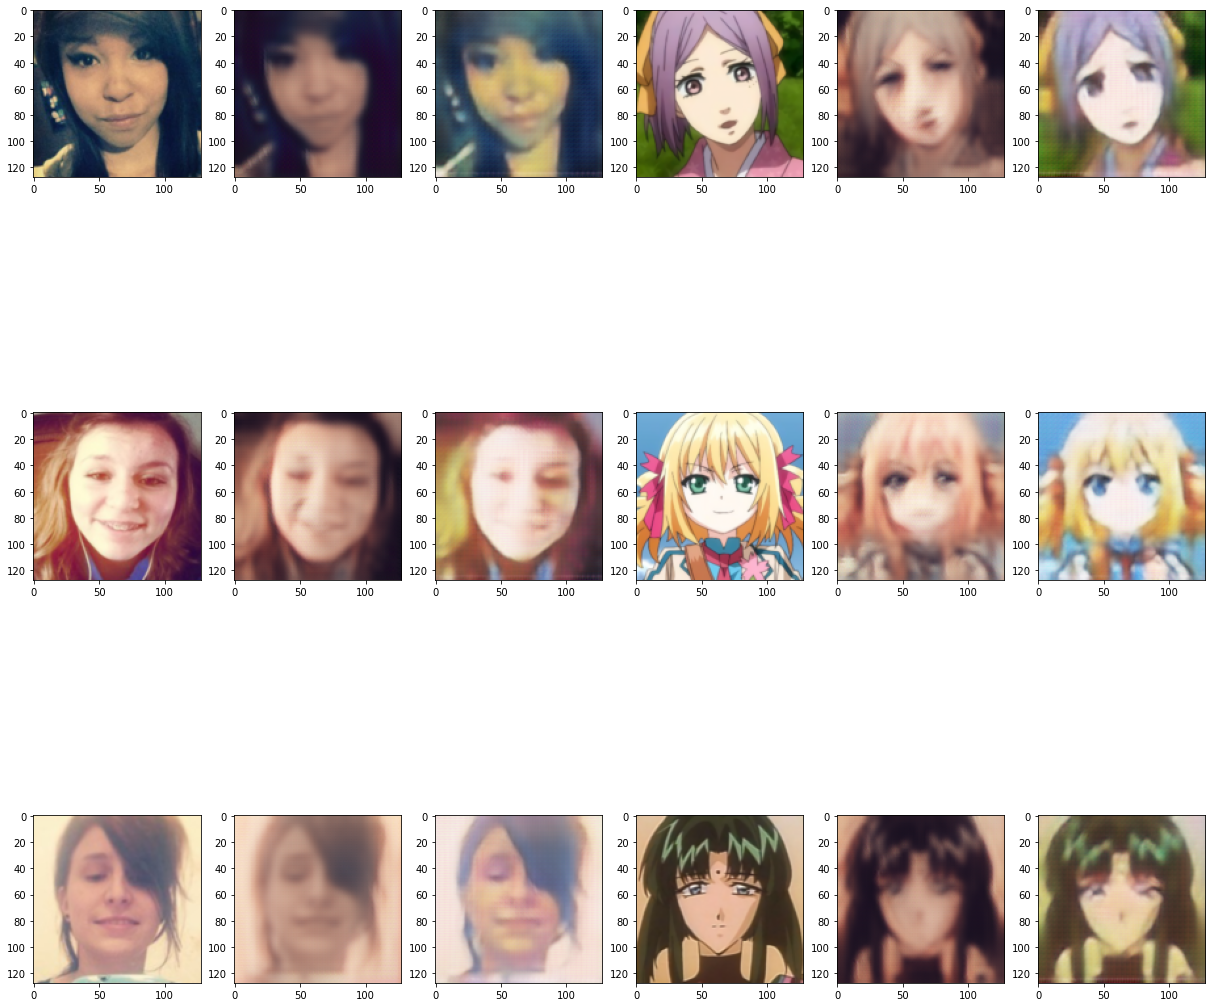

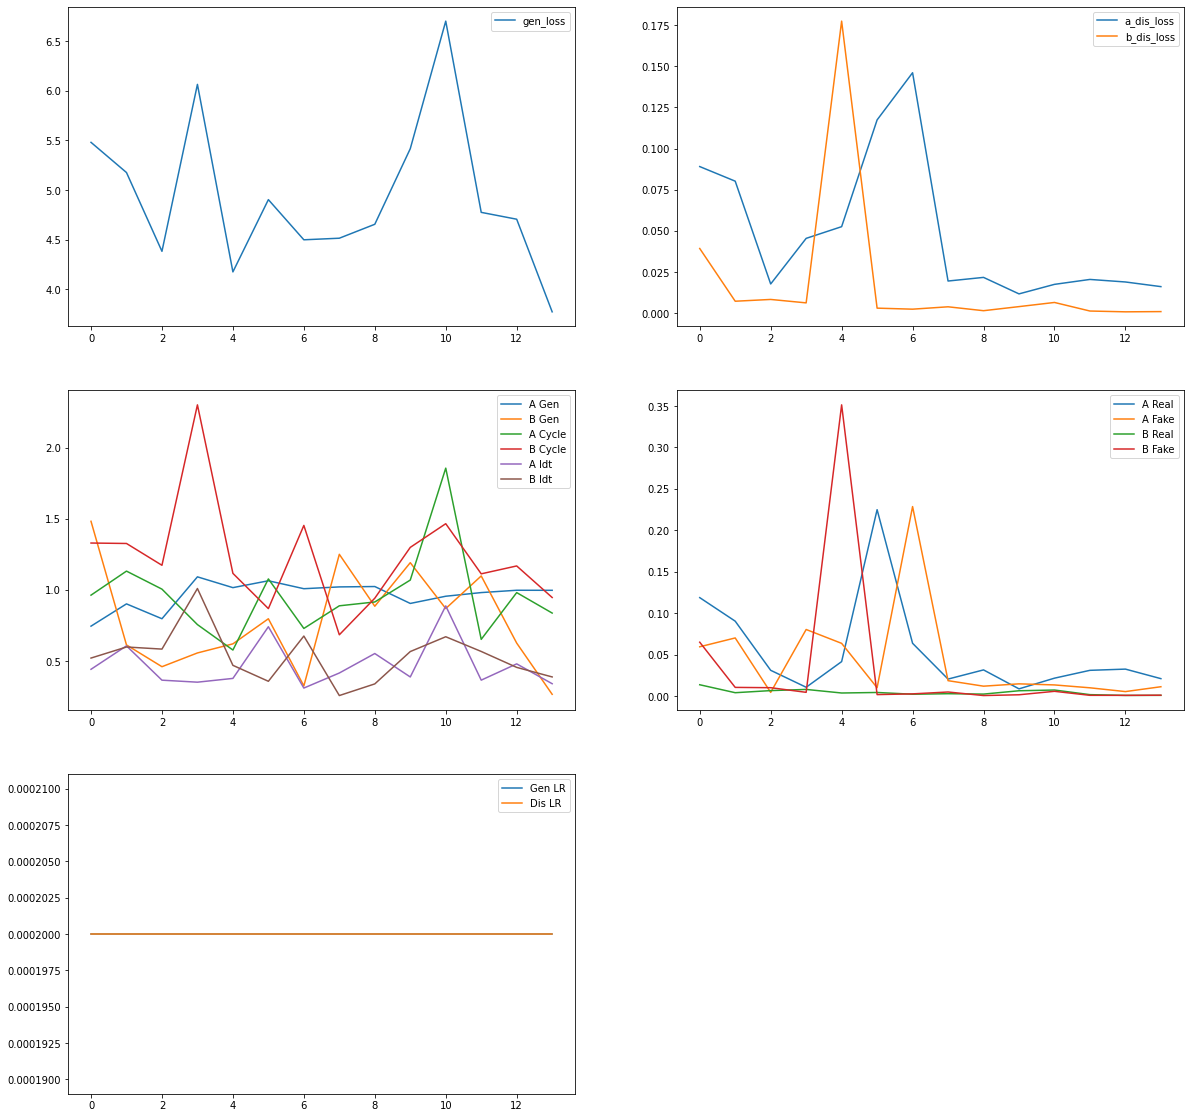

In [ ]:
checkpoint = torch.load(save_dir+'/'+SESSION)
print('PM is {}'.format(checkpoint['PM']))
print('Epoch is {}'.format(checkpoint['epoch']))
Gen_A1 = Generator_Res()
Gen_A1.load_state_dict(checkpoint['Gen_A_sd'])
Gen_B1 = Generator_Res()
Gen_B1.load_state_dict(checkpoint['Gen_B_sd'])

Visualize(Gen_A1.eval(), Gen_B1.eval(), LoaderA, LoaderB, checkpoint, [], picture=True, plot=True)

# WIP

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


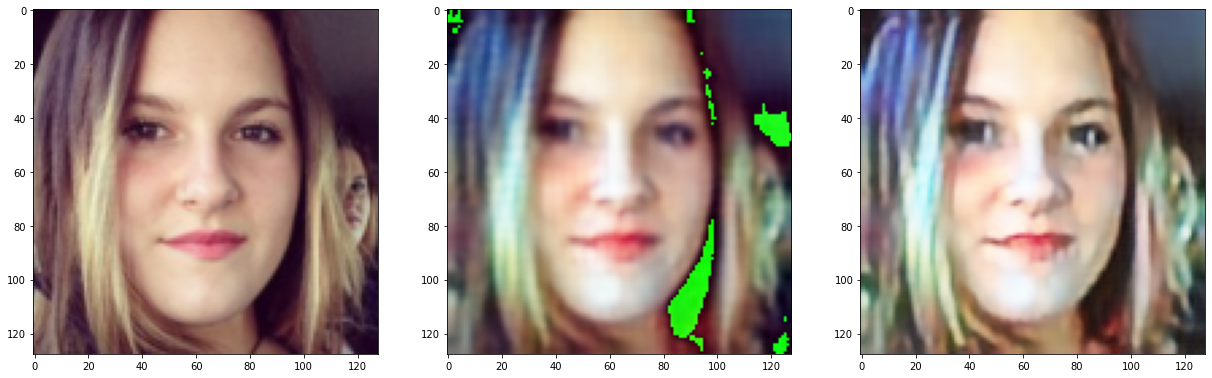

0.9843137


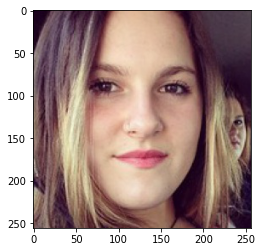

[[[ 28   3  33]
  [ 28   3  33]
  [ 28   3  32]
  ...
  [ 79  66  76]
  [ 83  71  81]
  [ 82  70  80]]

 [[ 27   2  32]
  [ 26   1  30]
  [ 25   0  29]
  ...
  [ 80  67  77]
  [ 82  70  80]
  [ 82  70  80]]

 [[ 27   2  31]
  [ 26   1  30]
  [ 25   1  27]
  ...
  [ 80  67  77]
  [ 79  67  77]
  [ 79  67  77]]

 ...

 [[ 83  52  49]
  [106  75  73]
  [115  85  85]
  ...
  [ 28   3  33]
  [ 28   3  32]
  [ 27   2  31]]

 [[ 79  48  46]
  [107  76  74]
  [118  88  88]
  ...
  [ 27   2  32]
  [ 27   2  31]
  [ 26   1  30]]

 [[ 81  50  48]
  [107  77  75]
  [124  94  94]
  ...
  [ 27   2  32]
  [ 27   2  31]
  [ 27   2  31]]]


In [ ]:
index = 0
loaded = LoaderA.dataset[index][0]
if use_cuda and torch.cuda.is_available():
  loaded = loaded.cuda()

control = loaded.cpu().detach().numpy()
control = np.transpose(control, [1,2,0])
print(loaded.shape)
print(loaded.unsqueeze(0).shape)

_result = Gen_A(loaded.unsqueeze(0))
result = _result.cpu().squeeze().detach().numpy()
result = np.transpose(result, [1,2,0])

_result2 = Gen_B(loaded.unsqueeze(0))
result2 = _result2.cpu().squeeze().detach().numpy()
result2 = np.transpose(result2, [1,2,0])

plt.figure(figsize=(21, 21))
plt.subplot(1,3,1)
plt.imshow(control)
plt.subplot(132)
plt.imshow((result*255).astype(np.uint8))
plt.subplot(133)
plt.imshow((result2*255).astype(np.uint8))
plt.show()

print(np.max(control))
img = Image.open(root_dir+'/'+'dataset/face2anime/ltrainA/trainA/female_10.jpg')
plt.figure()
plt.imshow(img)
plt.show()
print(np.array(img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


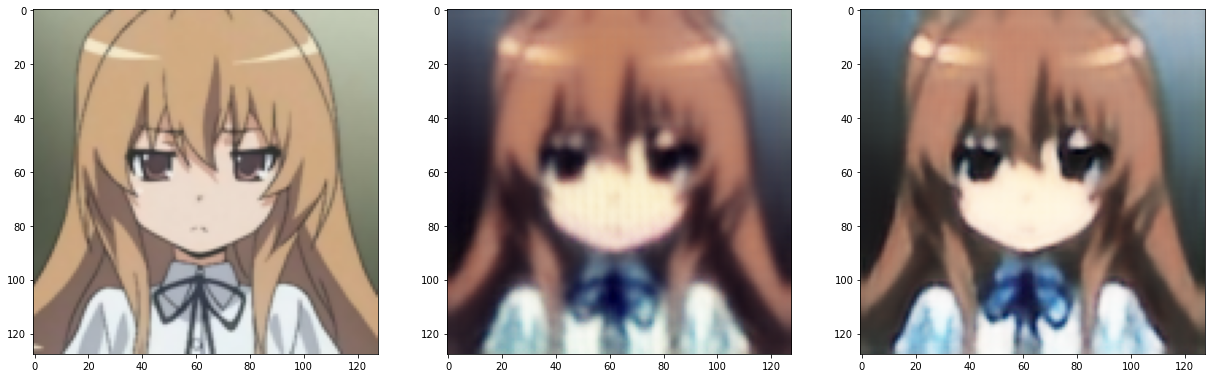

In [ ]:
index = 0
loaded = LoaderB.dataset[index][0]
if use_cuda and torch.cuda.is_available():
  loaded = loaded.cuda()

control = loaded.cpu()
control = np.transpose(control, [1,2,0])

_result = Gen_A(loaded.unsqueeze(0))
result = _result.cpu().squeeze().detach().numpy()
result = np.transpose(result, [1,2,0])

_result2 = Gen_B(loaded.unsqueeze(0))
result2 = _result2.cpu().squeeze().detach().numpy()
result2 = np.transpose(result2, [1,2,0])

plt.figure(figsize=(21, 21))
plt.subplot(131)
plt.imshow(control)
plt.subplot(132)
plt.imshow(result)
plt.subplot(133)
plt.imshow(result2)
plt.show()

In [ ]:
Gen_A.state_dict()

In [ ]:
sroot = 'drive/My Drive/CSC420/state_dict'

torch.save(Gen_A, sroot+'/250on50trial')


In [ ]:
Gen_A = torch.load(sroot+'/250on50trial')
